##### QVI Data Cleaning

Best-matched control stores: {11: np.int64(76), 1: np.int64(85)}


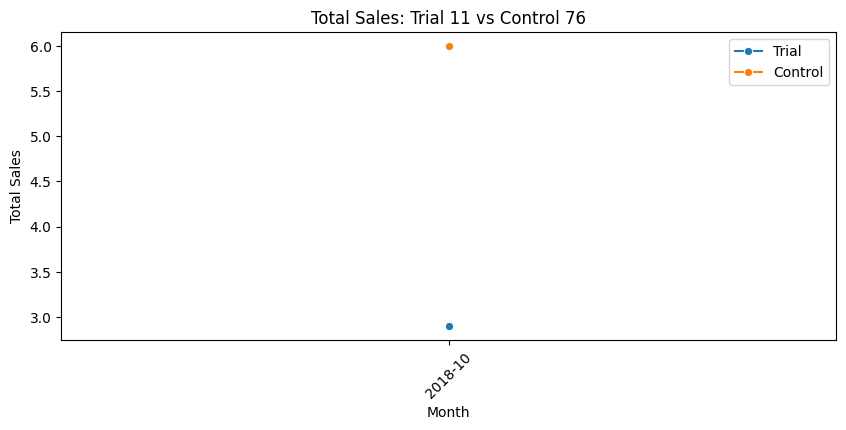


Trial store 11 vs Control store 76 during trial period:
   STORE_NBR_trial YearMonth  total_sales_trial  total_customers_trial  \
0               11   2018-10                2.9                      1   

   total_transactions_trial  avg_txns_per_customer_trial  STORE_NBR_control  \
0                         1                          1.0                 76   

   total_sales_control  total_customers_control  total_transactions_control  \
0                  6.0                        1                           1   

   avg_txns_per_customer_control  sales_diff  customer_diff  \
0                            1.0        -3.1              0   

   txns_per_customer_diff  
0                     0.0  
Average sales difference: -3.1
Average customer difference: 0.0
Average transactions per customer difference: 0.0


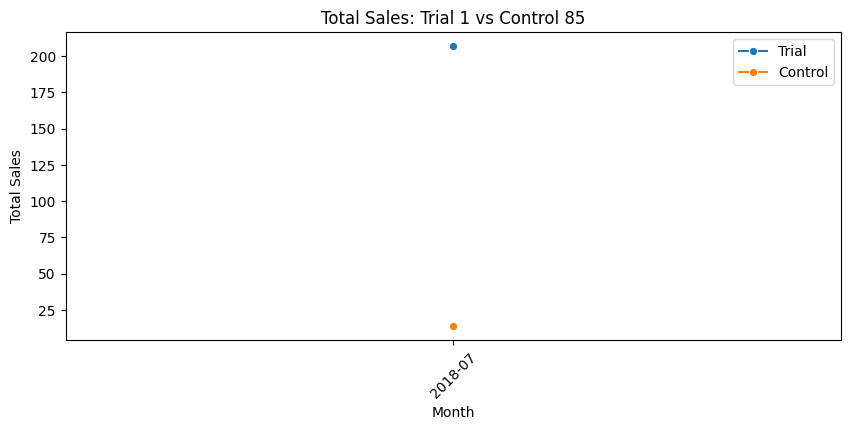


Trial store 1 vs Control store 85 during trial period:
   STORE_NBR_trial YearMonth  total_sales_trial  total_customers_trial  \
0                1   2018-07              206.9                     49   

   total_transactions_trial  avg_txns_per_customer_trial  STORE_NBR_control  \
0                        52                     1.061224                 85   

   total_sales_control  total_customers_control  total_transactions_control  \
0                 13.9                        3                           3   

   avg_txns_per_customer_control  sales_diff  customer_diff  \
0                            1.0       193.0             46   

   txns_per_customer_diff  
0                0.061224  
Average sales difference: 193.0
Average customer difference: 46.0
Average transactions per customer difference: 0.061224489795918435


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('QVI_data.csv')

# -----------------------------
# Helper function: similarity
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Compute similarity function
# -----------------------------
def compute_similarity(trial_store_metrics, control_store_metrics, metrics=['total_sales','total_customers','avg_txns_per_customer']):
    """
    Compute similarity between trial store and control store by aligning months.
    Returns similarity score (0-1)
    """
    # Align months
    merged = trial_store_metrics.merge(control_store_metrics, on='YearMonth', suffixes=('_trial','_control'))
    if merged.empty:
        return np.array([0])
    
    trial_vals = merged[[f"{m}_trial" for m in metrics]].values
    control_vals = merged[[f"{m}_control" for m in metrics]].values
    
    distances = np.linalg.norm(trial_vals - control_vals, axis=1)
    
    # Normalize distance to similarity
    if distances.max() - distances.min() == 0:
        similarity = np.ones_like(distances)
    else:
        similarity = 1 - (distances - distances.min()) / (distances.max() - distances.min())
    
    similarity = np.nan_to_num(similarity, nan=0.0)
    return similarity

# -----------------------------
# Select unique control stores
# -----------------------------
def select_control_stores_unique(monthly_metrics, trial_stores, pre_trial_period_months=6):
    """
    Select best-matched control store for each trial store (unique control per trial)
    """
    all_stores = monthly_metrics['STORE_NBR'].unique()
    available_controls = set(all_stores) - set(trial_stores)
    best_controls = {}
    
    latest_pretrial_month = monthly_metrics['YearMonth'].max() - pre_trial_period_months
    pre_trial_data = monthly_metrics[monthly_metrics['YearMonth'] <= latest_pretrial_month]
    
    for t in trial_stores:
        trial_data = pre_trial_data[pre_trial_data['STORE_NBR']==t].sort_values('YearMonth')
        sims = []
        control_ids = []
        
        for c in available_controls:
            control_data_c = pre_trial_data[pre_trial_data['STORE_NBR']==c].sort_values('YearMonth')
            sim_score = compute_similarity(trial_data, control_data_c)
            sims.append(sim_score.mean())
            control_ids.append(c)
        
        if sims:
            best_control = control_ids[np.argmax(sims)]
            best_controls[t] = best_control
            available_controls.remove(best_control)
        else:
            best_controls[t] = None
    
    return best_controls

# -----------------------------
# Main analysis function
# -----------------------------
def analyze_trial_vs_control(df, trial_stores, trial_period=('2018-07','2019-08'), pre_trial_period_months=6):
    """
    Analyze trial stores vs matched control stores.
    Returns results dict and best control stores.
    """
    # Ensure DATE is datetime
    df['DATE'] = pd.to_datetime(df['DATE'])
    
    # Extract YearMonth as Period
    df['YearMonth'] = df['DATE'].dt.to_period('M')
    
    # -----------------------------
    # Step 1: Compute monthly metrics
    # -----------------------------
    monthly_metrics = df.groupby(['STORE_NBR','YearMonth']).agg(
        total_sales=('TOT_SALES','sum'),
        total_customers=('LYLTY_CARD_NBR', pd.Series.nunique),
        total_transactions=('TXN_ID', pd.Series.nunique)
    ).reset_index()
    
    monthly_metrics['avg_txns_per_customer'] = monthly_metrics['total_transactions'] / monthly_metrics['total_customers']
    
    # -----------------------------
    # Step 2: Select best-matched unique control stores
    # -----------------------------
    best_controls = select_control_stores_unique(monthly_metrics, trial_stores, pre_trial_period_months)
    print("Best-matched control stores:", best_controls)
    
    # -----------------------------
    # Step 3: Prepare trial period
    # -----------------------------
    trial_start = pd.Period(trial_period[0], freq='M')
    trial_end = pd.Period(trial_period[1], freq='M')
    
    # Ensure trial period exists in dataset
    available_months = monthly_metrics['YearMonth'].unique()
    if trial_start < available_months.min():
        trial_start = available_months.min()
    if trial_end > available_months.max():
        trial_end = available_months.max()
    
    # -----------------------------
    # Step 4: Compare trial vs control
    # -----------------------------
    results = {}
    
    for t, c in best_controls.items():
        if c is None:
            print(f"No control store found for trial store {t}. Skipping.")
            continue
        
        trial_data = monthly_metrics[(monthly_metrics['STORE_NBR']==t) &
                                     (monthly_metrics['YearMonth'] >= trial_start) &
                                     (monthly_metrics['YearMonth'] <= trial_end)].sort_values('YearMonth')

        control_data = monthly_metrics[(monthly_metrics['STORE_NBR']==c) &
                                       (monthly_metrics['YearMonth'] >= trial_start) &
                                       (monthly_metrics['YearMonth'] <= trial_end)].sort_values('YearMonth')

        if trial_data.empty or control_data.empty:
            print(f"Skipping trial store {t} vs control store {c} — no overlapping data in trial period.")
            continue
        
        # Align months
        comparison = trial_data.merge(control_data, on='YearMonth', suffixes=('_trial','_control'))
        
        # Plot total sales
        plt.figure(figsize=(10,4))
        sns.lineplot(x=comparison['YearMonth'].astype(str), y=comparison['total_sales_trial'], marker='o', label='Trial')
        sns.lineplot(x=comparison['YearMonth'].astype(str), y=comparison['total_sales_control'], marker='o', label='Control')
        plt.title(f'Total Sales: Trial {t} vs Control {c}')
        plt.ylabel('Total Sales')
        plt.xlabel('Month')
        plt.xticks(rotation=45)
        plt.show()
        
        # Compute differences
        comparison['sales_diff'] = comparison['total_sales_trial'] - comparison['total_sales_control']
        comparison['customer_diff'] = comparison['total_customers_trial'] - comparison['total_customers_control']
        comparison['txns_per_customer_diff'] = comparison['avg_txns_per_customer_trial'] - comparison['avg_txns_per_customer_control']
        
        print(f"\nTrial store {t} vs Control store {c} during trial period:")
        print(comparison)
        print("Average sales difference:", comparison['sales_diff'].mean())
        print("Average customer difference:", comparison['customer_diff'].mean())
        print("Average transactions per customer difference:", comparison['txns_per_customer_diff'].mean())
        
        results[t] = {
            'control_store': c,
            'comparison': comparison
        }
    
    return results, best_controls



# -----------------------------
# Step 5: Run Analysis
# -----------------------------
# Example:
trial_stores = [11, 1]  # replace with your trial store numbers
trial_period = ('2018-07','2022-08')

best_controls = analyze_trial_vs_control(df, trial_stores, trial_period=trial_period, pre_trial_period_months=6)
